In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn import preprocessing, metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, validation_curve, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

#### Examining School Survey Data

In [2]:
spr = pd.read_csv('2010_-_2011_School_Progress_Reports_-_All_Schools.csv')

In [3]:
spr.head(2)

,DBN,DISTRICT,SCHOOL,PRINCIPAL,PROGRESS REPORT TYPE,SCHOOL LEVEL*,PEER INDEX*,2010-2011 OVERALL GRADE,2010-2011 OVERALL SCORE,2010-2011 ENVIRONMENT CATEGORY SCORE,2010-2011 ENVIRONMENT GRADE,2010-2011 PERFORMANCE CATEGORY SCORE,2010-2011 PERFORMANCE GRADE,2010-2011 PROGRESS CATEGORY SCORE,2010-2011 PROGRESS GRADE,2010-2011 ADDITIONAL CREDIT,2009-10 PROGRESS REPORT GRADE
0,01M015,1,P.S. 015 Roberto Clemente,Irene Sanchez,EMS,Elementary,63.61,C,27.0,6.4,B,2.1,D,18.0,C,0.5,C
1,01M019,1,P.S. 019 Asher Levy,Jacqueline Flanagan,EMS,Elementary,49.48,B,48.7,7.8,B,5.2,D,35.1,A,0.5,C


In [4]:
#extracting borough from dbn
spr['borough'] = spr.DBN.str[2]
set(spr.borough)

{'K', 'M', 'Q', 'R', 'X'}

In [5]:
#getting relevant columns
spr = spr[['DBN', '2010-2011 PROGRESS GRADE', 'borough']]
spr.rename(columns = {'2010-2011 PROGRESS GRADE': 'prog_grade'}, inplace = True)

In [6]:
#looking at null valuse
spr.isnull().sum() 

DBN            0
prog_grade    45
borough        0
dtype: int64

In [7]:
#dropping empty rows
spr.dropna(axis = 0, inplace = True)

In [8]:
#checking shape of new dataframe
spr.shape

(1174, 3)

In [9]:
#looking at count of each unique value in the dependent variable 
counts = spr.prog_grade.value_counts().reset_index()
counts.rename(columns = {'index':'grade'}, inplace = True)
counts.sort_values('grade', inplace = True)
counts.grade = counts.grade.astype(object)
counts

,grade,prog_grade
2,A,256
0,B,379
1,C,353
4,D,93
3,F,93


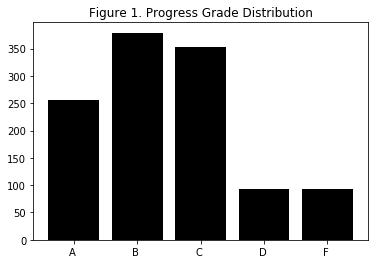

In [10]:
plt.bar(counts.grade, counts.prog_grade, color = 'black')
plt.title('Figure 1. Progress Grade Distribution')
plt.ylabel('')
plt.show()
#plt.savefig('grades_distribution.png', dpi = 600)

There is imbalance between in the outcome variables, with a small proportion of D and F grades being assigned. 

#### Converting outcome variable to quantitative 

In [11]:
le = preprocessing.LabelEncoder()
spr['prog_grade'] = le.fit_transform(spr['prog_grade'])
spr.prog_grade = spr.prog_grade.astype(float)

#### Examining income level  by borough data

In [12]:
income = pd.read_excel('Data2Go.NYC.4th.Edition.All.Variables.xlsx', sheet_name= 'Boro')

In [13]:
income.head(2)

,Unnamed: 0,DISPLAY NAME,American Human Development Index,Adult Stability (% of adults living in same house 1 year ago),Asian or Pacific Islander (% of total population),Asian or Pacific Islander Population (total #),Asian or Pacific Islander: 2000 (% of total population),Asian or Pacific Islander: Change Since 2000 (% change in pop. share),Black (% of total population),Black (% of total population).1,...,Private Wage and Salary Workers (% of all employed),Self-employed (% of all employed),TANF and General Assistance (% of households in past 12 months),Unemployed (% ages 16 and older),Unemployed Veterans (#),Unemployed Veterans (% of veteran population),Unpaid Family Worker (% of all employed),Veteran Poverty (# of veterans with incomes below poverty),Veteran Poverty (% of veterans with incomes below poverty),Work for Government (% of all employed)
0,Bronx,NaN,4.409757,90.89105,3.837652,56458,3.114321,23.225958,29.02913,29.02913,...,79.55176,5.851758,8.558588,6.580761,1107,8.239672,0.120764,2925,12.38252,14.47572
1,Brooklyn,NaN,6.141740,90.12918,12.198680,323115,7.596683,60.579033,30.09920,30.09920,...,78.93236,6.894592,5.031358,4.087040,941,4.735068,0.132670,4507,11.15677,14.04038


In [14]:
#getting relevant columns
income = income[['Unnamed: 0', 'Gini Coefficient of Income Inequality']]

In [15]:
income

,Unnamed: 0,Gini Coefficient of Income Inequality
0,Bronx,0.5108
1,Brooklyn,0.5314
2,Manhattan,0.5943
3,Queens,0.4472
4,Staten Island,0.4614


In [16]:
#checking for null values
income.isnull().sum()

Unnamed: 0                               0
Gini Coefficient of Income Inequality    0
dtype: int64

In [17]:
#renaming columns for easier reference
income.rename(columns = {'Gini Coefficient of Income Inequality':'income_inequality',
                        'Unnamed: 0':'borough'}, inplace = True)

In [18]:
#creating new column of borough name used in the dbn classification in school survey dataset
income['borough_abbr'] = np.where(income['borough'] == 'Brooklyn', 'K',
                                 np.where(income.borough == 'Bronx', 'X', 
                                         np.where(income.borough == 'Manhattan', 'M',
                                                 np.where(income.borough == 'Queens', 'Q', 'R'))))


In [19]:
income = income[['income_inequality', 'borough_abbr']]
income

,income_inequality,borough_abbr
0,0.5108,X
1,0.5314,K
2,0.5943,M
3,0.4472,Q
4,0.4614,R


#### Examinig general scores data

In [20]:
gen = pd.read_excel('2011nycdata/masterfile11_gened_final.xlsx')

In [21]:
gen.head(2)

,2011 School Survey for Community Schools\nPlease refer to the Data Dictionary file for more detailed information about the format of this data.,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 1927,Unnamed: 1928,Unnamed: 1929,Unnamed: 1930,Unnamed: 1931,Unnamed: 1932,Unnamed: 1933,Unnamed: 1934,Unnamed: 1935,Unnamed: 1936
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,dbn,schoolname,rr_s,rr_t,rr_p,N_s,N_t,N_p,nr_s,nr_t,...,s_N_q14e_3,s_N_q14e_4,s_N_q14f_1,s_N_q14f_2,s_N_q14f_3,s_N_q14f_4,s_N_q14g_1,s_N_q14g_2,s_N_q14g_3,s_N_q14g_4


In [22]:
#cleaning columns 
gen.columns = gen.iloc[1]
gen = gen[2:]

In [23]:
gen.head(2)

1,dbn,schoolname,rr_s,rr_t,rr_p,N_s,N_t,N_p,nr_s,nr_t,...,s_N_q14e_3,s_N_q14e_4,s_N_q14f_1,s_N_q14f_2,s_N_q14f_3,s_N_q14f_4,s_N_q14g_1,s_N_q14g_2,s_N_q14g_3,s_N_q14g_4
2,01M015,P.S. 015 Roberto Clemente,NaN,88,60,NaN,22,90,0,25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01M019,P.S. 019 Asher Levy,NaN,100,60,NaN,34,161,0,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
#extracting relevant columns 
cols = ['dbn','saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']

In [25]:
sub = gen[cols]

In [26]:
#getting count of missing values
sub.isnull().sum() * 100 / len(gen)

1
dbn           0.0
saf_tot_11    0.0
com_tot_11    0.0
eng_tot_11    0.0
aca_tot_11    0.0
dtype: float64

In [27]:
#converting columns to numeric
sub[['saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']] = sub[['saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']].astype(float)


In [28]:
sub.describe()

1,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
count,1646.000000,1646.000000,1646.000000,1646.000000
mean,7.776124,7.189186,7.435237,7.904435
std,0.834853,0.781646,0.738756,0.671358
min,0.000000,0.000000,0.000000,0.000000
25%,7.200000,6.700000,7.000000,7.500000
50%,7.800000,7.200000,7.400000,7.900000
75%,8.375000,7.700000,7.900000,8.300000
max,9.700000,9.300000,9.300000,9.700000


In [29]:
sub.median()

1
saf_tot_11    7.8
com_tot_11    7.2
eng_tot_11    7.4
aca_tot_11    7.9
dtype: float64

In [30]:
sub.mode()

1,dbn,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,01M015,8.3,6.9,7.1,7.7
1,01M019,NaN,NaN,NaN,NaN
2,01M020,NaN,NaN,NaN,NaN
3,01M034,NaN,NaN,NaN,NaN
4,01M063,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1641,84X705,NaN,NaN,NaN,NaN
1642,84X706,NaN,NaN,NaN,NaN
1643,84X717,NaN,NaN,NaN,NaN
1644,84X718,NaN,NaN,NaN,NaN


#### Combining datasets

In [31]:
data = pd.merge(sub, spr, left_on = 'dbn', right_on = 'DBN', how = 'inner')

In [32]:
data.head()

,dbn,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,DBN,prog_grade,borough
0,01M015,8.0,7.7,7.5,7.9,01M015,2.0,M
1,01M019,8.5,8.1,8.2,8.4,01M019,0.0,M
2,01M020,8.2,7.3,7.5,8.0,01M020,1.0,M
3,01M034,7.3,6.7,7.1,7.9,01M034,2.0,M
4,01M063,8.5,7.6,7.9,8.0,01M063,1.0,M


In [33]:
data = pd.merge(data, income, left_on = 'borough', right_on = 'borough_abbr', how = 'left')

In [34]:
data.head()

,dbn,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,DBN,prog_grade,borough,income_inequality,borough_abbr
0,01M015,8.0,7.7,7.5,7.9,01M015,2.0,M,0.5943,M
1,01M019,8.5,8.1,8.2,8.4,01M019,0.0,M,0.5943,M
2,01M020,8.2,7.3,7.5,8.0,01M020,1.0,M,0.5943,M
3,01M034,7.3,6.7,7.1,7.9,01M034,2.0,M,0.5943,M
4,01M063,8.5,7.6,7.9,8.0,01M063,1.0,M,0.5943,M


#### Splitting dataset into target and independent vars 

In [35]:
X = data[['saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11', 'income_inequality']]
y = data.prog_grade
         

#### Looking at distribution of numeric columns 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1292896a0>,
      dtype=object)

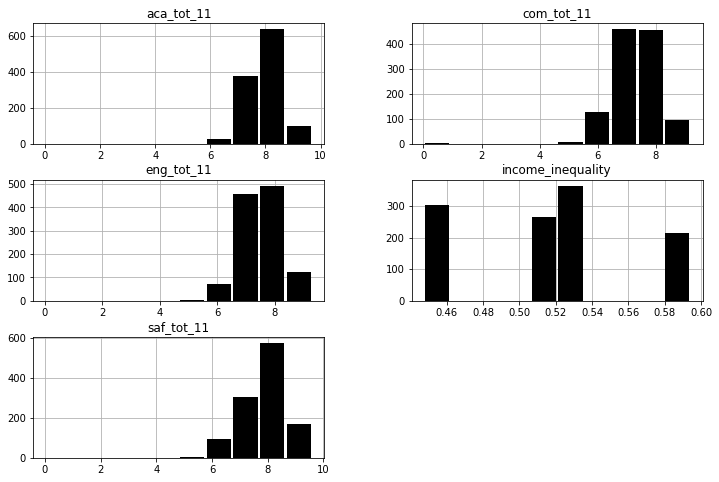

In [36]:
X.hist(figsize=(12,8), color='black', zorder=2, rwidth=0.9)

The columns are not normally distributed so they need to be normalized

#### Splitting data in training and test set 

In [37]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)


#### Running linear regression model

In [38]:
#the independent variables are skewed so they need to be 
#  normalized to run the linear regresson. 
model = LinearRegression(fit_intercept=True, normalize = True)
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [39]:
#fitting linear regression model
model.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [40]:
# assessing model fit otn training data
model.score(Xtrain, ytrain)

0.08714658474709891

In [41]:
#assessing the model fit
model.score(Xtest, ytest)

0.05674587432345157

In [42]:
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
saf_tot_11,-0.446871
com_tot_11,0.578488
eng_tot_11,0.387597
aca_tot_11,-0.986459
income_inequality,-0.171945


In [43]:
#generating predictions
ypred = model.predict(Xtest)

In [44]:
predictions = pd.DataFrame({'Actual': ytest, 'Predicted': ypred})
predictions = predictions.head(10)
predictions

,Actual,Predicted
934,2.0,1.726429
120,0.0,1.474557
694,1.0,1.867508
965,2.0,1.291804
1101,1.0,0.878977
1113,2.0,1.313051
135,2.0,1.511078
395,4.0,2.112061
194,3.0,1.736619
997,2.0,1.126364


In [45]:
# The mean squared error
print('Root Mean squared error: %.2f'
      % np.sqrt(mean_squared_error(ytest, ypred)))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(ytest, ypred))

Root Mean squared error: 1.11
Coefficient of determination: 0.06


This linear regression clearly does not produce good results.

#### Running KNN

In [46]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(Xtrain, ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [47]:
#examining validation curve
prior_set = range(1,15)
train_scores, test_scores = validation_curve(knn, Xtrain, ytrain, param_name='n_neighbors',
                                            param_range=prior_set, cv=10)

In [48]:
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

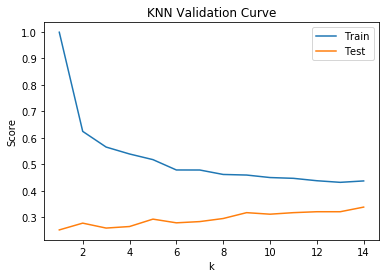

In [49]:
pos_class = range(1,15)
fig1 = plt.figure()
plt.plot(pos_class, train_mean, label='Train')
plt.plot(pos_class, test_mean, label='Test')
plt.xlabel('k')
plt.ylabel('Score')
plt.title('KNN Validation Curve')
plt.legend()
plt.show()

In [50]:
#trying KNN with 5 groups
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(Xtrain, ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [51]:
# Model validation
scores = cross_val_score(knn, Xtest, ytest, cv = 5,scoring='accuracy')
scores.mean()

0.3413793103448276

However, this does not produce very good results so I will try with a different number of groups. 

In [52]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(Xtrain,ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

In [53]:
# Model validation
scores = cross_val_score(knn, Xtest, ytest, cv = 9, scoring='accuracy')
scores.mean()

0.3655913978494624

With neighbors equal to 11 gives a better validation score. 

In [54]:
#getting prediction to make confusion matrix
knn_y_pred = knn.predict(Xtest)

In [55]:
print(confusion_matrix(ytest, knn_y_pred))
print(classification_report(ytest, knn_y_pred))

[[17 27 13  1  0]
 [13 50 21  1  0]
 [21 45 31  0  1]
 [12  5  5  0  0]
 [ 9  5 10  0  0]]
              precision    recall  f1-score   support

         0.0       0.24      0.29      0.26        58
         1.0       0.38      0.59      0.46        85
         2.0       0.39      0.32      0.35        98
         3.0       0.00      0.00      0.00        22
         4.0       0.00      0.00      0.00        24

    accuracy                           0.34       287
   macro avg       0.20      0.24      0.21       287
weighted avg       0.29      0.34      0.31       287



In [56]:
print("Accuracy:",metrics.accuracy_score(ytest, knn_y_pred))

Accuracy: 0.34146341463414637
